# House Price Predictions
In this assessment, we'll predict house prices using a model. We will complete the following tasks:

- Load the houseprices data from Thinkful's database.
- Split your data into train and test sets.
- Estimate your model from the previous lesson in the training set. Assess the goodness of fit of your model.
- Predict the house prices in the test set, and evaluate the performance of your model using the metrics previously mentioned in this lesson.
- Is the performance of your model satisfactory? Why or why not?
- Try to improve your model in terms of predictive performance by adding or removing some variables.

First, we load the houseprices data from the database and import relevant libraries.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine, text

# Display preferences
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

house_price_df = pd.read_sql_query(text('SELECT * FROM houseprices'), con=engine.connect())

# No need for an open connection, because you're only doing a single query
engine.dispose()

In [2]:
house_price_df.head(10)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.000,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.000,14115,Pave,None,IR1,Lvl,AllPub,...,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.000,10084,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,...,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.000,6120,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.000,7420,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,1,2008,WD,Normal,118000


In a previous lesson we found that the non-numerical features `mszoning`,`street`,`utilities`,`bsmtqual`, and `salecondition` are important to the sale price. Therefore, we will turn them into dummy variables.

In [3]:
dummy_column_names = []
def convert_to_dummy(df, names, dummy_column_names):
  for name in names:
    df = pd.concat([df,pd.get_dummies(df[name], prefix=name, drop_first=True)], axis=1)
  for name in names:
    dummy_column_names = dummy_column_names + list(pd.get_dummies(df[name], prefix=name, drop_first=True).columns)
  return df, dummy_column_names

house_price_df, dummy_column_names = convert_to_dummy(house_price_df, ['mszoning','street','utilities','bsmtqual','salecondition'], dummy_column_names)

Next, we will estimate the model with the non-numerical features above and the numerical variables `overallqual`, `grlivarea`, `garagecars`, `garagearea`, and `totalbsmtsf`.

In [4]:
X = house_price_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf'] + dummy_column_names]
Y = house_price_df['saleprice']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)
print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

# The constant acts as a "baseline" of the data in case all of your features'
# values are 0.
X_train = sm.add_constant(X_train)

# Fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# Print the summary results
print(results.summary())

The number of observations in training set is 1168
The number of observations in test set is 292
                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     224.9
Date:                Tue, 14 Nov 2023   Prob (F-statistic):               0.00
Time:                        04:11:32   Log-Likelihood:                -13919.
No. Observations:                1168   AIC:                         2.788e+04
Df Residuals:                    1148   BIC:                         2.798e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

The R-squared and the adjusted R-squared of the model are 0.788 and 0.785 respectively. Hence, according to the R-squared, around 21% of the variance in the target variable is unexplained by the model. AIC and BIC scores are 27,880 and 27,980 respectively.

Now, let's evaluate the test set performance:

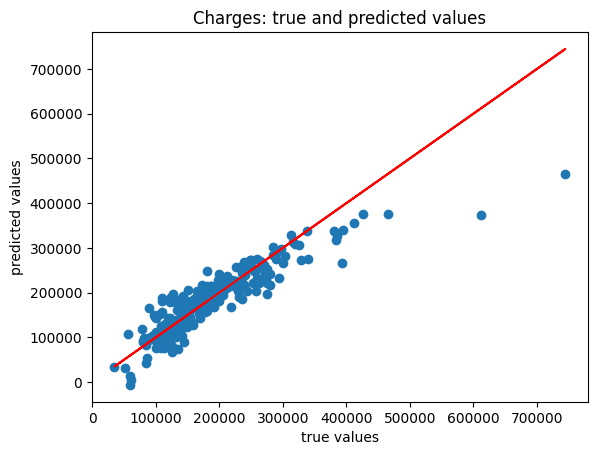

Mean absolute error of the prediction is: 23644.103341968057
Mean squared error of the prediction is: 1299307338.758636
Root mean squared error of the prediction is: 36045.90599164676
Mean absolute percentage error of the prediction is: 14.44857525269772


In [5]:
# Add a constant to the model because it's best practice
# to do so every time!
X_test = sm.add_constant(X_test)

# You are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))


Is this model accurate? We can improve the model by increasing the goodness of fit. To do this, we execute the steps below:

- We first log transform the dependent variable. Recall from the histogram above that the `saleprice` variable is not normally distributed, so log transforming may help in this regard. To this end, we apply `log(1+x)` transformation of NumPy.
- Second, we create another variable by summing up the basement, first and the second floor areas.
- Third, we add the interaction of the total area and the overall quality of the house.
- Fourth, we drop the explanatory variable that aren't statistically significant.

In [6]:
house_price_df2 = house_price_df.copy()
unwanted_features = ['mszoning_FV','mszoning_RH',
                     'mszoning_RM','street_Pave',
                    'utilities_NoSeWa','salecondition_AdjLand',
                    'salecondition_Alloca','salecondition_Family']
dummy_column_names2 = [e for e in dummy_column_names if e not in unwanted_features]


In [7]:
house_price_df2['totalsf'] = house_price_df2['totalbsmtsf'] + house_price_df2['firstflrsf'] + house_price_df2['secondflrsf']
house_price_df2['int_over_sf'] = house_price_df2['totalsf'] * house_price_df2['overallqual']

# Y is the target variable
Y = np.log1p(house_price_df2['saleprice'])
# X is the feature set
X = house_price_df2[['overallqual', 'grlivarea', 'garagecars', 'totalbsmtsf', 'totalsf', 'int_over_sf'] + dummy_column_names2]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)
print("The number of observations in the training set is {}".format(X_train.shape[0]))
print("The number of observations in the test set is {}".format(X_test.shape[0]))

# Add a constant to the model because it's best practice
# to do so every time!
X_train = sm.add_constant(X_train)

# Fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# Print the summary results
print(results.summary())

The number of observations in the training set is 1168
The number of observations in the test set is 292
                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     494.5
Date:                Tue, 14 Nov 2023   Prob (F-statistic):               0.00
Time:                        04:11:32   Log-Likelihood:                 481.41
No. Observations:                1168   AIC:                            -936.8
Df Residuals:                    1155   BIC:                            -871.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
---------------

The R-squared and the adjusted R-squared of the model are 0.837 and 0.835 respectively. Hence, according to the R-squared, around 16% of the variance in the target variable is unexplained by the model. AIC and BIC scores are -936.8 and -871 respectively. So, the goodness of fit in the second model is significantly better than the first.

Now, let's evaluate the test set performance for the second model:

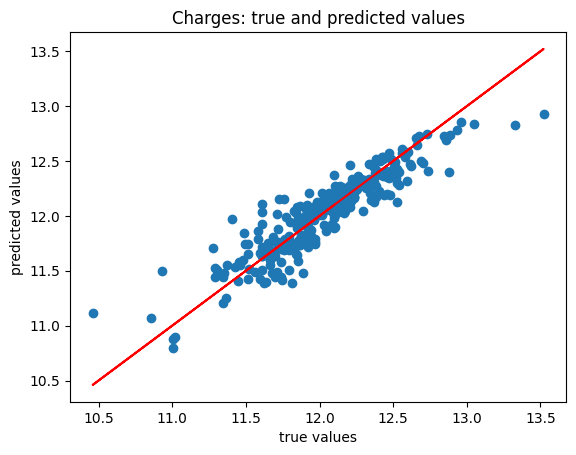

Mean absolute error of the prediction is: 0.1258319732191756
Mean squared error of the prediction is: 0.028389323022913204
Root mean squared error of the prediction is: 0.1684913143841937
Mean absolute percentage error of the prediction is: 1.0516003019586515


In [8]:
# Add a constant to the model because it's best practice
# to do so every time!
X_test = sm.add_constant(X_test)

# You are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

These are significantly lower than the first model. So, the second model achieves much better prediction performance than the first model.